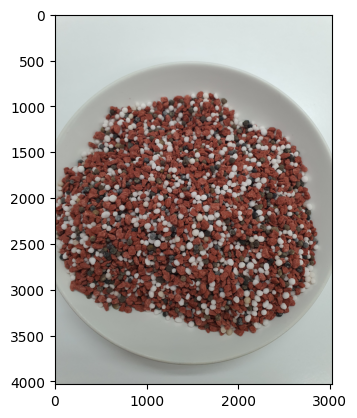

In [1]:
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
import torch
import os
import matplotlib.pyplot as plt

# === Load the image ===
folder_path_1 = "D:/2D/pictures/14-7-35"
folder_path_2 = "D:/2D/pictures/15-7-18"
folder_path_3 = "D:/2D/pictures/15-15-15"
folder_path_4 = "D:/2D/pictures/18-4-5"
images_path_1 = [os.path.join(folder_path_1, f) for f in os.listdir(folder_path_1) if f.endswith('.jpg')]
images_path_2 = [os.path.join(folder_path_2, f) for f in os.listdir(folder_path_2) if f.endswith('.jpg')]
images_path_3 = [os.path.join(folder_path_3, f) for f in os.listdir(folder_path_3) if f.endswith('.jpg')]
images_path_4 = [os.path.join(folder_path_4, f) for f in os.listdir(folder_path_4) if f.endswith('.jpg')]

# Optional: visualize the image (for debugging)
image_bgr = cv2.imread(images_path_1[1])  # Load the first image from the first folder
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()


Filtered edge-based box: [  41  576 2998 3365]


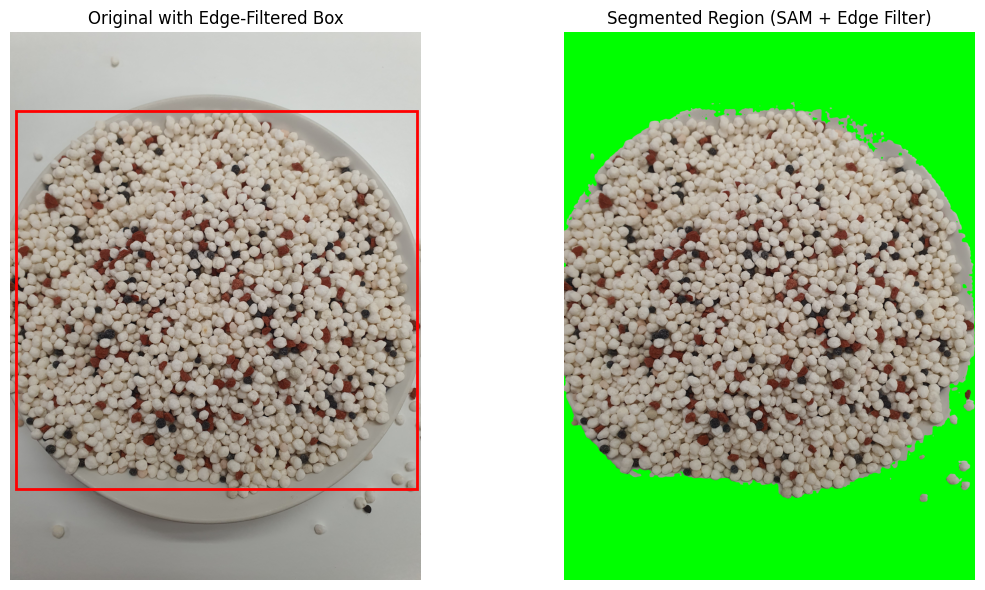

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamPredictor

# === Load SAM model ===
sam_checkpoint = "models/sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# === Load image ===
img_path = images_path_4[10]  # Your image list
image_bgr = cv2.imread(img_path)
if image_bgr is None:
    raise FileNotFoundError(f"Image not found at: {img_path}")

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
predictor.set_image(image_rgb)

# === Enhanced Edge-Based Bounding Box ===
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 30, 100)

# Morphological cleanup
kernel = np.ones((3, 3), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)
edges = cv2.erode(edges, kernel, iterations=1)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out large, small, or border-touching contours
filtered_contours = []
h, w = image_rgb.shape[:2]
for c in contours:
    x, y, cw, ch = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    if area < 500 or area > 0.5 * h * w:
        continue  # Ignore tiny or huge (plate) regions
    if x <= 5 or y <= 5 or x + cw >= w - 5 or y + ch >= h - 5:
        continue  # Likely touching image border (e.g., plate edge)
    filtered_contours.append(c)

if not filtered_contours:
    raise RuntimeError("No valid contours found after edge filtering.")

# Merge filtered grain contours into one box
all_points = np.vstack(filtered_contours)
x, y, cw, ch = cv2.boundingRect(all_points)
input_box = np.array([x, y, x + cw, y + ch])
print(f"Filtered edge-based box: {input_box}")

# === SAM segmentation ===
masks, scores, logits = predictor.predict(
    box=input_box,
    multimask_output=True
)
best_mask = masks[np.argmax(scores)]

# === Visualize ===
masked_image = image_rgb.copy()
masked_image[~best_mask] = [0, 255, 0]  # Show background in green

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original with Edge-Filtered Box")
plt.gca().add_patch(plt.Rectangle(
    (input_box[0], input_box[1]),
    input_box[2] - input_box[0],
    input_box[3] - input_box[1],
    edgecolor='red',
    linewidth=2,
    facecolor='none'
))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.title("Segmented Region (SAM + Edge Filter)")
plt.axis('off')

plt.tight_layout()
plt.show()

Enhancing image...
Start: Showing original image...


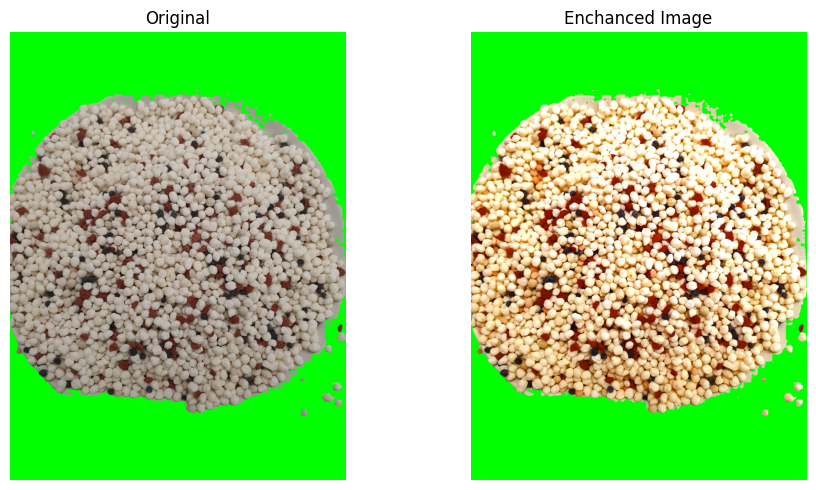

Getting image shape and flattening pixels...
Filtering out pure green pixels...
Running KMeans clustering into 4 clusters...


c:\Python\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Python\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cw

Preparing valid indices for mapping back...
Processing each cluster to create masks and points...


Clusters:  25%|██▌       | 1/4 [00:02<00:06,  2.18s/it]

Cluster 0: mask created with 2277813 points.


Clusters:  50%|█████     | 2/4 [00:03<00:03,  1.52s/it]

Cluster 1: mask created with 1185273 points.


Clusters:  75%|███████▌  | 3/4 [00:05<00:01,  1.81s/it]

Cluster 2: mask created with 2541646 points.


Clusters: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]

Cluster 3: mask created with 1173612 points.
Sorting clusters by total RGB brightness...
All clusters processed. Starting visualization...


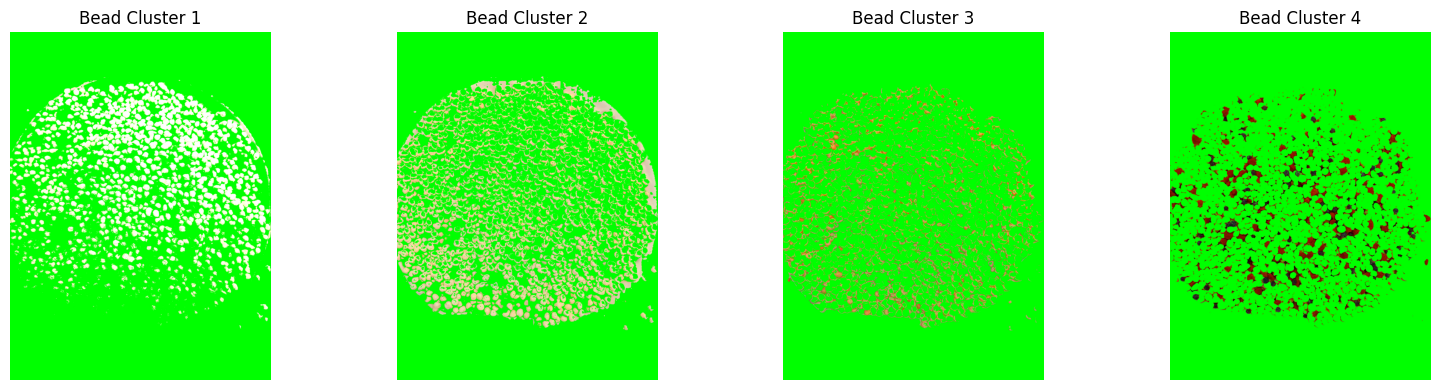

In [4]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm  # Progress bar

# === CONFIG ===
BEAD_MASKS = 4             # Number of clusters
CONTRAST_FACTOR = 1.5       # >1 increases contrast
SATURATION_FACTOR = 2.5     # >1 increases vividity
BRIGHTNESS_OFFSET = -10     # Offset for brightness adjustment

# === Image enhancement with comprehensive clipping ===
def enhance_image(image, contrast=CONTRAST_FACTOR, saturation=SATURATION_FACTOR, brightness=BRIGHTNESS_OFFSET):
    # Create a mask for pure green pixels (RGB = [0, 255, 0])
    green_mask = np.all(image == [0, 255, 0], axis=-1)

    # Backup green pixels
    green_pixels = image[green_mask]

    # Ensure input is float32 for precise calculations
    img = np.clip(image.astype(np.float32), 0, 255)

    # Apply brightness adjustment with clipping
    img = np.clip(img + brightness, 0, 255)

    # Apply contrast with clipping
    img = np.clip(contrast * img, 0, 255)

    # Convert to uint8 for HSV conversion
    img_uint8 = img.astype(np.uint8)

    # Convert to HSV and apply saturation boost
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[..., 1] = np.clip(hsv[..., 1] * saturation, 0, 255)
    hsv = np.clip(hsv, 0, 255)

    # Convert back to RGB
    enhanced = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)

    # Restore the original green pixels
    enhanced[green_mask] = green_pixels

    return enhanced



# === Grouping points ===
def get_all_grouped_points(label):
    point_coords = []
    group_indices = np.where(labels == label)[0]
    for indice in group_indices:
        original_flat_index = valid_indices[indice]
        y, x = divmod(original_flat_index, W)
        point_coords.append([x, y])
    return np.array(point_coords)

print("Enhancing image...")
enhanced_image = enhance_image(masked_image)

# === Processing starts here ===
print("Start: Showing original image...")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(masked_image)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title("Enchanced Image")
plt.axis('off')
plt.tight_layout()
plt.show()

print("Getting image shape and flattening pixels...")
H, W, _ = enhanced_image.shape
pixels = enhanced_image.reshape(-1, 3)

print("Filtering out pure green pixels...")
non_black_indices = np.any(pixels != [0, 255, 0], axis=1)
pixels_non_black = pixels[non_black_indices]

print("Running KMeans clustering into", BEAD_MASKS, "clusters...")
kmeans = KMeans(n_clusters=BEAD_MASKS, random_state=42)
labels = kmeans.fit_predict(pixels_non_black)

print("Preparing valid indices for mapping back...")
valid_indices = np.where(non_black_indices)[0]

all_masks = []
all_point_coords = []

print("Processing each cluster to create masks and points...")
for cluster_label in tqdm(range(BEAD_MASKS), desc="Clusters"):
    mask_flat = np.zeros(H * W, dtype=bool)
    cluster_pixel_indices = valid_indices[labels == cluster_label]
    mask_flat[cluster_pixel_indices] = True
    mask_2d = mask_flat.reshape(H, W)
    point_coords = get_all_grouped_points(cluster_label)
    all_masks.append(mask_2d)
    all_point_coords.append(point_coords)
    print(f"Cluster {cluster_label}: mask created with {len(point_coords)} points.")

print("Sorting clusters by total RGB brightness...")

# Compute total brightness for each mask
brightness_sums = []
for mask in all_masks:
    masked_pixels = enhanced_image[mask]
    brightness = np.sum(masked_pixels)  # Sum of R + G + B
    brightness_sums.append(brightness)

# Get sorted indices from brightest to darkest
sorted_indices = np.argsort(brightness_sums)[::-1]  # Descending order

# Reorder clusters by brightness
all_masks = [all_masks[i] for i in sorted_indices]
all_point_coords = [all_point_coords[i] for i in sorted_indices]

print("All clusters processed. Starting visualization...")

plt.figure(figsize=(16, 4))
for i in range(BEAD_MASKS):
    cluster_img = np.full_like(enhanced_image, fill_value=[0, 255, 0])  # Green background
    mask = all_masks[i]
    cluster_img[mask] = enhanced_image[mask]  # Overlay original colors of cluster

    plt.subplot(1, BEAD_MASKS, i + 1)
    plt.imshow(cluster_img)
    plt.title(f"Bead Cluster {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

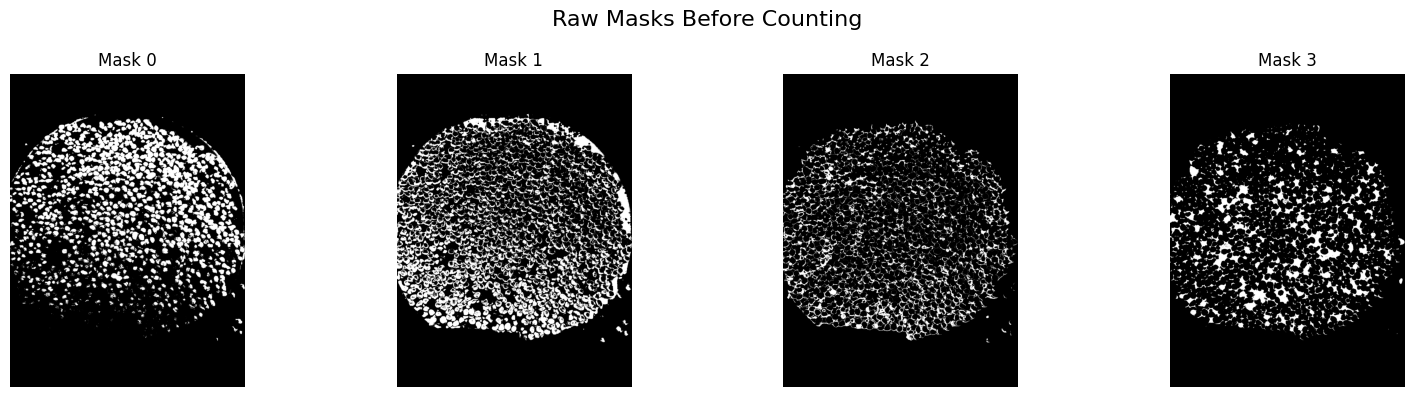

Counting beads with SAM...


Clusters: 100%|██████████| 4/4 [00:37<00:00,  9.38s/it]


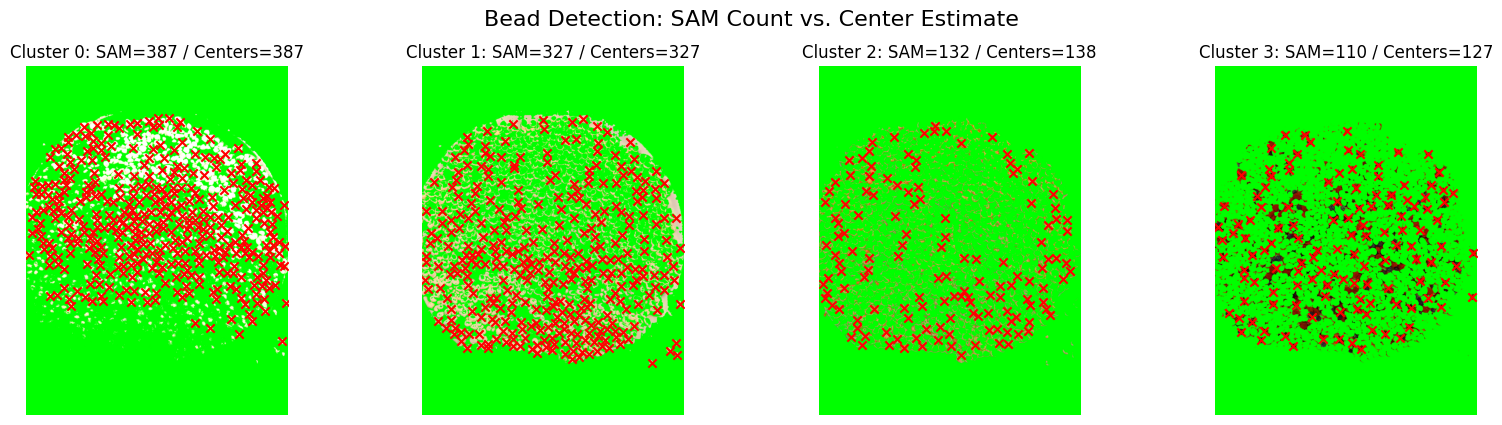


Summary:
Cluster 1: 387 beads counted by SAM from 387 estimated centers
Cluster 2: 327 beads counted by SAM from 327 estimated centers
Cluster 3: 132 beads counted by SAM from 138 estimated centers
Cluster 4: 110 beads counted by SAM from 127 estimated centers
Total SAM-counted beads: 956
Total estimated centers: 979


In [5]:
from sklearn.cluster import KMeans
from segment_anything import SamPredictor, sam_model_registry
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from tqdm import tqdm


# === Config ===
sam_checkpoint = "models/sam_vit_b_01ec64.pth"
model_type = "vit_b"
BEAD_MASKS = 4


# === Initialize SAM ===
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)


# === Function to detect bead centers using contours ===
def get_centers(mask, min_area=1500, min_dist=10):
    centers = []
    mask_uint8 = (mask * 255).astype(np.uint8)

    # Clean up noise slightly
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask_uint8, cv2.MORPH_OPEN, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) > min_area:
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                if all(np.hypot(cx - x, cy - y) > min_dist for x, y in centers):
                    centers.append((cx, cy))
    return centers


# === Visualize masks before counting ===
plt.figure(figsize=(16, 4))
for i, mask in enumerate(all_masks):
    plt.subplot(1, BEAD_MASKS, i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask {i}")
    plt.axis('off')
plt.suptitle("Raw Masks Before Counting", fontsize=16)
plt.tight_layout()
plt.show()


# === Count beads with SAM ===
print("Counting beads with SAM...")
all_counts, all_centers = [], []
predictor.set_image(enhanced_image)

for i, mask in enumerate(tqdm(all_masks, desc="Clusters")):
    centers = get_centers(mask)
    count = 0
    for x, y in centers:
        try:
            masks, scores, _ = predictor.predict(
                point_coords=np.array([[x, y]]),
                point_labels=np.array([1]),
                multimask_output=True
            )
            best_mask = masks[np.argmax(scores)]
            # Adjust the value below based on output quality
            if np.sum(best_mask) > 80 and np.sum(mask & best_mask) / np.sum(best_mask) > 0.10:
                count += 1
        except:
            continue
    all_counts.append(count)
    all_centers.append(centers)


# === Visualization ===
plt.figure(figsize=(16, 8))
for i, (mask, centers) in enumerate(zip(all_masks, all_centers)):
    cluster_img = np.full_like(enhanced_image, [0, 255, 0])
    cluster_img[mask] = enhanced_image[mask]
    plt.subplot(2, BEAD_MASKS, i + 1)
    plt.imshow(cluster_img)
    if centers:
        cx, cy = zip(*centers)
        plt.scatter(cx, cy, c='red', marker='x')
    plt.title(f"Cluster {i}: SAM={all_counts[i]} / Centers={len(centers)}")
    plt.axis('off')
plt.suptitle("Bead Detection: SAM Count vs. Center Estimate", fontsize=16)
plt.tight_layout()
plt.show()


print("\nSummary:")
for i, (c, centers) in enumerate(zip(all_counts, all_centers)):
    print(f"Cluster {i+1}: {c} beads counted by SAM from {len(centers)} estimated centers")
print("Total SAM-counted beads:", sum(all_counts))
print("Total estimated centers:", sum(len(c) for c in all_centers))


In [9]:
print(all_counts)

[387, 327, 132, 110]


In [10]:
def get_npk(all_counts):
    
    white_beads = all_counts[0]
    red_beads = all_counts[1]
    stain_beads = all_counts[2]
    black_beads = all_counts[3]

    white_composition = {'N': 46, 'P': 0, 'K': 0}
    red_composition   = {'N': 0, 'P': 0, 'K': 60}
    stain_composition = {'N': 21, 'P': 0, 'K': 0}
    black_composition = {'N': 18, 'P': 46, 'K': 0}

    npk_total = {'N': 0, 'P': 0, 'K': 0}

    for key in npk_total:
        npk_total[key] += red_composition[key] * red_beads
        npk_total[key] += white_composition[key] * white_beads
        npk_total[key] += stain_composition[key] * stain_beads
        npk_total[key] += black_composition[key] * black_beads

    total_beads = sum(all_counts)
    npk_composition = {key: round(val / total_beads, 2) for key, val in npk_total.items()}
    
    return npk_composition

print(f"NPK Composition: {get_npk(all_counts)} in percantage")

NPK Composition: {'N': 23.59, 'P': 5.29, 'K': 20.52} in percantage


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 69.39it/s]


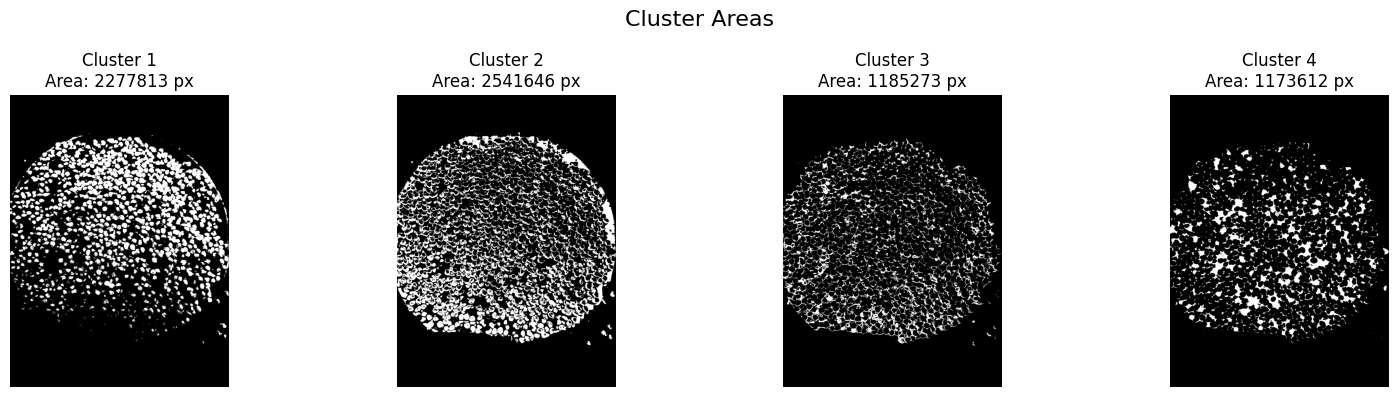


Cluster Area Summary:
Cluster 1: 2277813 pixels
Cluster 2: 2541646 pixels
Cluster 3: 1185273 pixels
Cluster 4: 1173612 pixels
Total Cluster Area: 7178344


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# === Assuming `all_masks` is a list of boolean or binary masks (H x W) ===
# all_masks = [...]  # This should already be created before this script runs

# === Compute Cluster Areas ===
cluster_areas = []
for i, mask in enumerate(tqdm(all_masks, desc="Measuring cluster areas")):
    area = np.sum(mask > 0)  # Counts all non-zero (i.e., masked) pixels
    cluster_areas.append(area)

# === Visualization of Mask with Area ===
plt.figure(figsize=(16, 4))
for i, (mask, area) in enumerate(zip(all_masks, cluster_areas)):
    plt.subplot(1, len(all_masks), i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Cluster {i+1}\nArea: {area} px")
    plt.axis('off')
plt.suptitle("Cluster Areas", fontsize=16)
plt.tight_layout()
plt.show()

# === Print Area Summary ===
print("\nCluster Area Summary:")
for i, area in enumerate(cluster_areas):
    print(f"Cluster {i+1}: {area} pixels")

print("Total Cluster Area:", sum(cluster_areas))

In [7]:

print(cluster_areas)

[2277813, 2541646, 1185273, 1173612]


In [8]:
def get_npk(cluster_areas):
    
    shadow_area = 200000  # Area of the shadow

    white_beads = cluster_areas[0]
    stain_beads = cluster_areas[1]
    red_beads = cluster_areas[2]
    black_beads = cluster_areas[3] - shadow_area

    white_composition = {'N': 46, 'P': 0, 'K': 0}
    red_composition   = {'N': 0, 'P': 0, 'K': 60}
    stain_composition = {'N': 21, 'P': 0, 'K': 0}
    black_composition = {'N': 18, 'P': 46, 'K': 0}

    npk_total = {'N': 0, 'P': 0, 'K': 0}

    for key in npk_total:
        npk_total[key] += red_composition[key] * red_beads
        npk_total[key] += white_composition[key] * white_beads
        npk_total[key] += stain_composition[key] * stain_beads
        npk_total[key] += black_composition[key] * black_beads

    total_beads = sum(cluster_areas) - shadow_area
    npk_composition = {key: round(val / total_beads, 2) for key, val in npk_total.items()}
    
    return npk_composition

print(f"NPK Composition: {get_npk(cluster_areas)} in percantage")

NPK Composition: {'N': 25.17, 'P': 6.42, 'K': 10.19} in percantage


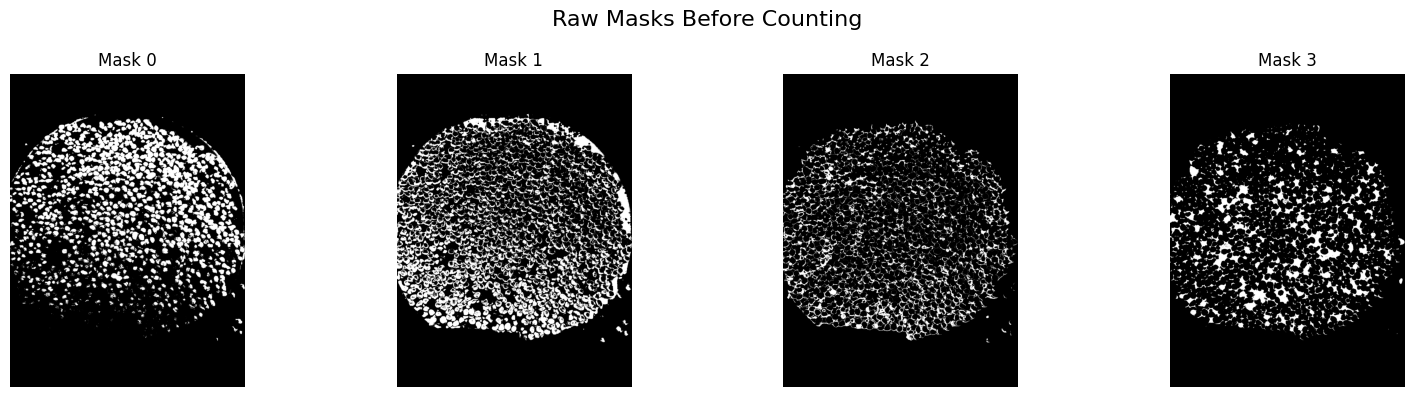

Counting Beads: 100%|██████████| 4/4 [00:37<00:00,  9.30s/it]



SAM Bead Count Summary:
Cluster 1: 387 beads from 387 centers
Cluster 2: 327 beads from 327 centers
Cluster 3: 132 beads from 138 centers
Cluster 4: 110 beads from 127 centers
Total SAM-counted beads: 956
NPK Composition from Count: {'N': 27.88, 'P': 5.29, 'K': 8.28}


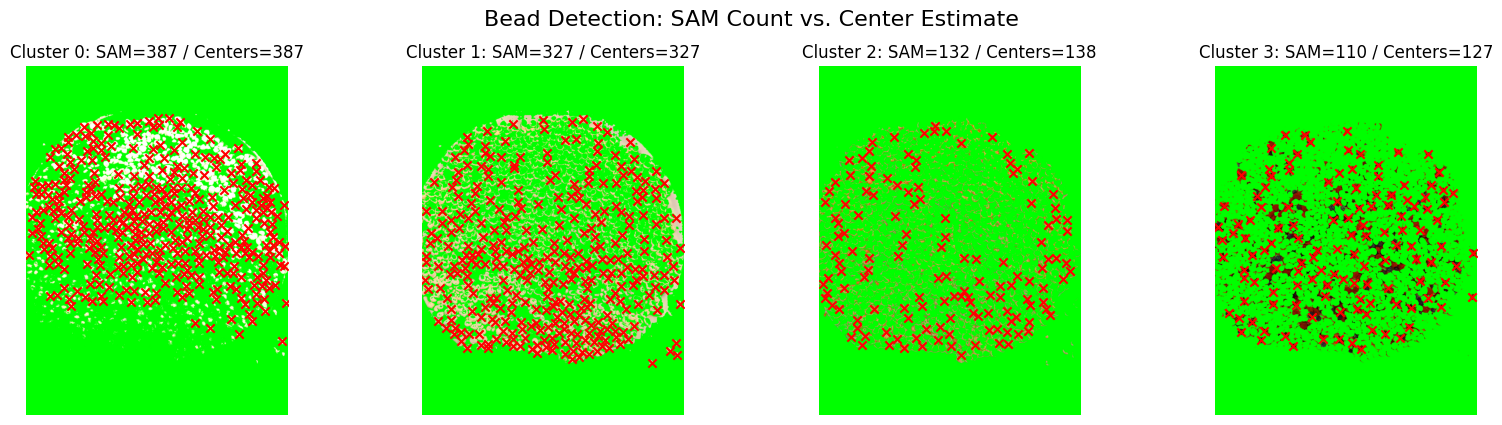

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from tqdm import tqdm
from segment_anything import SamPredictor, sam_model_registry

# === Configuration ===
sam_checkpoint = "models/sam_vit_b_01ec64.pth"
model_type = "vit_b"
BEAD_MASKS = 4
shadow_area = 200000  # Used for black cluster area correction
use_area_mode = False  # Set to True to compute NPK from area, False to use SAM count

# === Initialize SAM ===
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

# === Nutrient Composition Dictionary ===
npk_profiles = {
    "white": {'N': 46, 'P': 0, 'K': 0},
    "red":   {'N': 0,  'P': 0, 'K': 60},
    "stain": {'N': 21, 'P': 0, 'K': 0},
    "black": {'N': 18, 'P': 46,'K': 0}
}


# === Utility: Detect Bead Centers ===
def get_centers(mask, min_area=1500, min_dist=10):
    centers = []
    mask_uint8 = (mask * 255).astype(np.uint8)
    cleaned = cv2.morphologyEx(mask_uint8, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) > min_area:
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx, cy = int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])
                if all(np.hypot(cx - x, cy - y) > min_dist for x, y in centers):
                    centers.append((cx, cy))
    return centers


# === Visualize Raw Masks ===
def show_masks(all_masks, title="Raw Masks Before Counting"):
    plt.figure(figsize=(16, 4))
    for i, mask in enumerate(all_masks):
        plt.subplot(1, BEAD_MASKS, i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {i}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# === SAM-based Counting ===
def sam_count_beads(image, masks):
    predictor.set_image(image)
    all_counts, all_centers = [], []

    for mask in tqdm(masks, desc="Counting Beads"):
        centers = get_centers(mask)
        count = 0
        for x, y in centers:
            try:
                sam_masks, scores, _ = predictor.predict(
                    point_coords=np.array([[x, y]]),
                    point_labels=np.array([1]),
                    multimask_output=True
                )
                best_mask = sam_masks[np.argmax(scores)]
                if np.sum(best_mask) > 80 and np.sum(mask & best_mask) / np.sum(best_mask) > 0.10:
                    count += 1
            except:
                continue
        all_counts.append(count)
        all_centers.append(centers)
    return all_counts, all_centers


# === Area Computation ===
def compute_cluster_areas(masks):
    return [int(np.sum(mask > 0)) for mask in masks]


# === Visualization of Results ===
def visualize_clusters(image, masks, centers_list, counts):
    plt.figure(figsize=(16, 8))
    for i, (mask, centers) in enumerate(zip(masks, centers_list)):
        cluster_img = np.full_like(image, [0, 255, 0])
        cluster_img[mask] = image[mask]
        plt.subplot(2, BEAD_MASKS, i + 1)
        plt.imshow(cluster_img)
        if centers:
            cx, cy = zip(*centers)
            plt.scatter(cx, cy, c='red', marker='x')
        plt.title(f"Cluster {i}: SAM={counts[i]} / Centers={len(centers)}")
        plt.axis('off')
    plt.suptitle("Bead Detection: SAM Count vs. Center Estimate", fontsize=16)
    plt.tight_layout()
    plt.show()


# === NPK Estimation ===
def get_npk(values, from_area=False):
    white = values[0]
    stain = values[1]
    red   = values[2]
    black = values[3] - (shadow_area if from_area else 0)

    npk_total = {key: 0 for key in 'NPK'}
    for key in npk_total:
        npk_total[key] += npk_profiles["white"][key] * white
        npk_total[key] += npk_profiles["stain"][key] * stain
        npk_total[key] += npk_profiles["red"][key]   * red
        npk_total[key] += npk_profiles["black"][key] * black

    total_units = sum(values) - (shadow_area if from_area else 0)
    return {key: round(val / total_units, 2) for key, val in npk_total.items()}


# === Main Pipeline ===
# Assumes `all_masks` and `enhanced_image` are already defined
show_masks(all_masks)

if use_area_mode:
    cluster_areas = compute_cluster_areas(all_masks)
    print(f"\nCluster Area Summary:\n" + "\n".join(f"Cluster {i+1}: {a} px" for i, a in enumerate(cluster_areas)))
    print("Total Cluster Area:", sum(cluster_areas))
    print("NPK Composition from Area:", get_npk(cluster_areas, from_area=True))
else:
    all_counts, all_centers = sam_count_beads(enhanced_image, all_masks)
    print(f"\nSAM Bead Count Summary:\n" + "\n".join(f"Cluster {i+1}: {c} beads from {len(all_centers[i])} centers" for i, c in enumerate(all_counts)))
    print("Total SAM-counted beads:", sum(all_counts))
    print("NPK Composition from Count:", get_npk(all_counts))
    visualize_clusters(enhanced_image, all_masks, all_centers, all_counts)
